##Importing necessary libraries

In [1]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import numpy as np
import pandas as pd
import cv2
import keras
import matplotlib.pyplot as plt
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = "keshavmalanib21cs038"
os.environ['KAGGLE_KEY']= "5288201eb4ec1af8506e61aee9641f85"


##Downloading the data 

In [4]:
!kaggle datasets download tawsifurrahman/covid19-radiography-database

 99% 774M/778M [00:03<00:00, 217MB/s]
100% 778M/778M [00:03<00:00, 221MB/s]


In [5]:
!unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

##Reading the data

In [6]:
l=['COVID','Lung_Opacity','Normal','Viral Pneumonia']

In [7]:
img_path=[]
# mask_path=[]
label=[]

In [8]:
for i in l:
  k=os.listdir("COVID-19_Radiography_Dataset/"+ i + "/images")
  m=os.listdir("COVID-19_Radiography_Dataset/"+ i + "/masks")
  for j in range(len(k)):
    # print(j)
    img_path.append("COVID-19_Radiography_Dataset/"+ i + "/images/"+k[j])
    # mask_path.append("COVID-19_Radiography_Dataset/"+ i + "/masks/"+m[j])
    label.append(i)

In [9]:
df=pd.DataFrame(img_path,columns = ['image_file'])
# df['mask_file']=mask_path
df['label']=label
df

,image_file,label
0,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
1,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
2,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
3,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
4,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
...,...,...
21160,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,Viral Pneumonia
21161,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,Viral Pneumonia
21162,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,Viral Pneumonia
21163,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,Viral Pneumonia


#Preprocessing and loading the data

In [10]:
x=[]
y=[]
# y2=[]
for i in range(len(df)):
    image = cv2.imread(df['image_file'][i])
    image = cv2.resize(image, (80, 80))/255.0
   
    label = 0
    # label2= 0
    if df['label'][i] == "Normal":
        label = 0
        # label2=0
    elif df['label'][i] == "COVID":
        label = 1
        # label2= 1
    elif df['label'][i] == "Lung_Opacity":
        label = 0
        # label2=0
    else:
        label = 0
        # labwl2= 0
    x.append(image)
    y.append(label)
    # y2.append(label2)

In [11]:
x = np.array(x)
y = np.array(y)
# y2 = np.array(y2)
 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(15238, 80, 80, 3) (4233, 80, 80, 3) (1694, 80, 80, 3) (15238,) (4233,) (1694,)


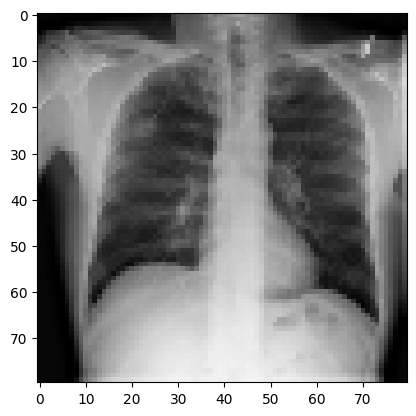

In [21]:
plt.imshow(x_train[0])

In [12]:
del x
del y

#Creating the model

In [13]:
def create_model(n_classes, train_shape):
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = train_shape))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.3))

    cnn_model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.5))

    cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dense(units = 256, activation = 'relu'))
    
    cnn_model.add(layers.Dropout(0.2))
    cnn_model.add(layers.Dense(units = 64, activation = 'relu'))

    cnn_model.add(layers.Dense(units = 32,activation='relu'))
    cnn_model.add(layers.Dense(units = 2))
    cnn_model.compile(optimizer = 'adam', 
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
               metrics = ['accuracy'])

    cnn_model.summary()
    return cnn_model

In [14]:
input_shape = (80, 80,3)
n_classes= 2

conv_model2 = create_model(n_classes, input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 39, 39, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 18, 18, 32)        0

#Running the model

In [15]:
plot_loss_2 = PlotLossesCallback()

tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

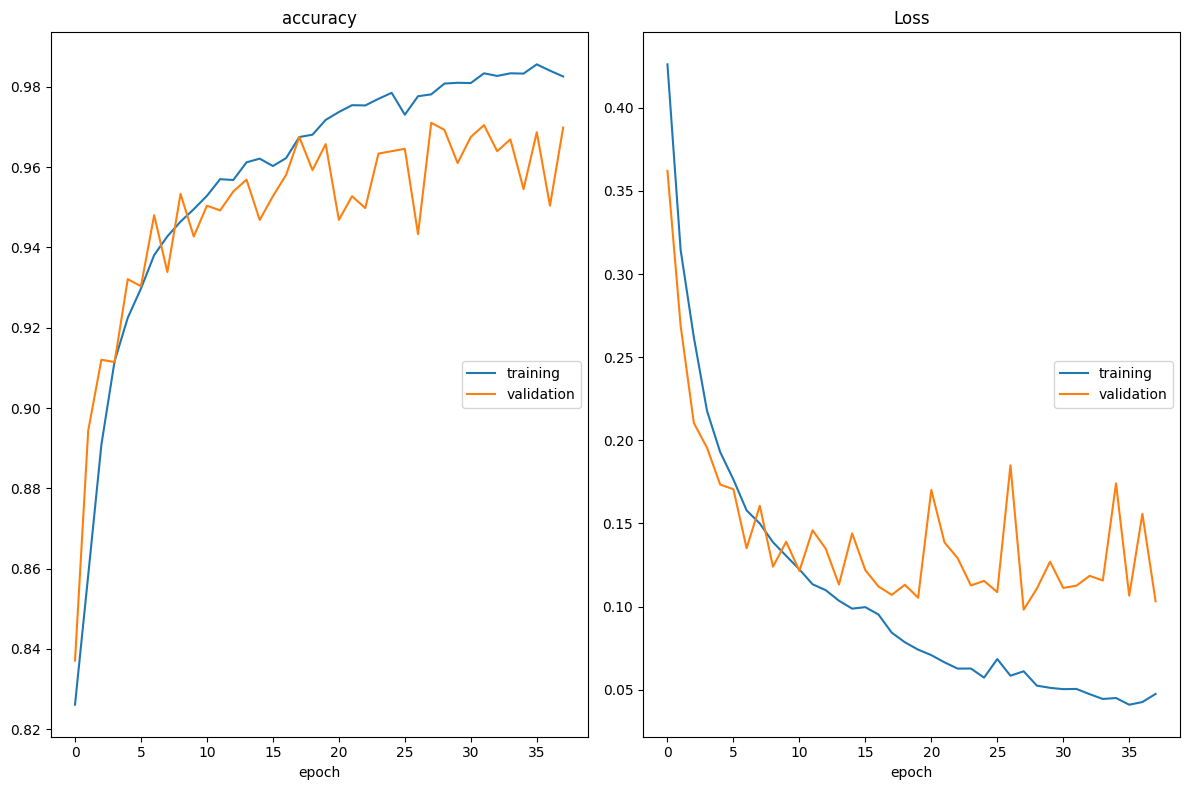

accuracy
	training         	 (min:    0.826, max:    0.986, cur:    0.983)
	validation       	 (min:    0.837, max:    0.971, cur:    0.970)
Loss
	training         	 (min:    0.041, max:    0.426, cur:    0.047)
	validation       	 (min:    0.098, max:    0.362, cur:    0.103)
239/239 [==============================] - 4s 17ms/step - loss: 0.0475 - accuracy: 0.9826 - val_loss: 0.1032 - val_accuracy: 0.9699
CPU times: user 2min 10s, sys: 12.1 s, total: 2min 22s
Wall time: 2min 18s


In [17]:
%%time

plot_loss_2 = PlotLossesCallback()

conv_history = conv_model2.fit(x_train, y_train, 
                        epochs = 50, batch_size = 64,  
                        validation_data = (x_val, y_val), 
                        callbacks = [tl_checkpoint_1, early_stop, plot_loss_2],
                       verbose=1)

#Evaluating the model

In [18]:
yp_train = conv_model2.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = conv_model2.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = conv_model2.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

133/133 [==============================] - 1s 4ms/step


In [19]:
def confusion_matrix_train_test_val(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")

    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")


In [20]:
confusion_matrix_train_test_val("CNN", y_train, yp_train, y_val, yp_val, y_test, yp_test)


-----------------------------CNN-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12599
           1       0.98      0.98      0.98      2639

    accuracy                           0.99     15238
   macro avg       0.99      0.99      0.99     15238
weighted avg       0.99      0.99      0.99     15238

--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1418
           1       0.92      0.91      0.91       276

    accuracy                           0.97      1694
   macro avg       0.95      0.94      0.95      1694
weighted avg       0.97      0.97      0.97      1694

--------------------------------------------------------------------------

Classification Report for Test Data

            